# Hourly PSDS - IROMY | WROMY | ROMY

## Load Libraries

In [1]:
from obspy import UTCDateTime
from scipy.signal import welch
from numpy import log10, zeros, pi, append, linspace, mean, median, array, where, transpose, shape, histogram, arange
from numpy import logspace, linspace, log, log10, isinf, ones, nan, count_nonzero, sqrt, isnan
from pandas import DataFrame, concat, Series, date_range, read_csv, read_pickle
from tqdm import tqdm
from pathlib import Path

import os, sys
import pickle
import matplotlib.pyplot as plt

from andbro__querrySeismoData import __querrySeismoData
from andbro__savefig import __savefig

In [2]:
def __get_minimal_psd(psds):

    from numpy import nanmin, array, nonzero

    min_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:,f]
        min_psd[f] = nanmin(a[nonzero(a)])

    return min_psd

In [3]:
def __get_median_psd(psds):

    from numpy import median, zeros, isnan

    med_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:,f]
        med_psd[f] = median(a[~isnan(a)])

    return med_psd

In [4]:
def __get_minimum_psd(psds, f_tmp):

    for i, psd in enumerate(psds):
        if i == 0:
            lowest_value = psd.sum()
            idx = 0

        value = psd.sum()

        if value < lowest_value and value != 0:
            lowest_value = value
            idx = i

    return psds[idx]

In [5]:
def __get_array_from_dataframe(df):

    from pandas import to_numeric

    ## convert to list
    psds = []
    for col in array(df.columns):

        ## turn non-float series to float objects
        df[col] = to_numeric(df[col], errors = 'coerce')

        ## add to psds list
        psds.append(array(df[col]))

    return array(psds)

In [6]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [7]:
## ---------------------------------------


# name = "WROMY"
# inname = "2023_WROMY_3600"
# subdir = "WROMY/"
# threshold = 8e-1
# f_limits = 1/1600, 1.0


name = "IROMY"  ## "WROMY_WS7"
inname = "2023_IROMY_3600"  ## "2023_WROMY_WS7_3600"
subdir = "IROMY/"  ## "WROMY_WS7/"
threshold = 8e-1
f_limits = 1/1600, 1.0



## ---------------------------------------

path = data_path+f"LNM2/PSDS/"

## load configurations
config = pickle.load(open(path+subdir+inname+"_config.pkl", 'rb'))

config['inname'] = inname
config['inpath'] = path+subdir
config['f_limits'] = f_limits
config['thres'] = threshold
config['station'] = name

config['outpath_figures'] = data_path+f"LNM2/figures/"

config['frequency_limits'] = [config['f_limits'][0], config['f_limits'][1]]


In [8]:
!ls /import/kilauea-data/LNM2/PSDS/IROMY

2023_IROMY_3600_20230813_hourly.pkl  2023_IROMY_3600_20230818_hourly.pkl
2023_IROMY_3600_20230814_hourly.pkl  2023_IROMY_3600_20230819_hourly.pkl
2023_IROMY_3600_20230815_hourly.pkl  2023_IROMY_3600_20230820_hourly.pkl
2023_IROMY_3600_20230816_hourly.pkl  2023_IROMY_3600_config.pkl
2023_IROMY_3600_20230817_hourly.pkl  2023_IROMY_3600_frequency_axis.pkl


## Methods

In [9]:
def __filter_psds(psds, thresholds):

    from numpy import mean, array

    psds_filtered = []
        ## filter mean psds values
#         m_psd = mean(psd)
#         if m_psd > thresholds[0] and m_psd < thresholds[1]:
#             psds_filtered.append(psd)

    ## filter for periods larger than 20 seconds
    if mean(psd[0:63]) < thresholds[0]:
        psds_filtered.append(psd)

    print(f" -> removed {len(psds)- len(psds_filtered)} of {len(psds)} psds due to thresholds: {thresholds[0]} & {thresholds[1]}")
    return array(psds_filtered)

In [10]:
def __load_data_file(path, file):

    from tqdm.notebook import tqdm
    from numpy import array

    psds_all = []
    psds_hourly = read_pickle(path+file)

    for psd in psds_hourly:
        psds_all.append(psd)

    return array(psds_all)

In [11]:
def __cut_frequencies_array(arr, freqs, fmin, fmax):

    ind = []
    for i, f in enumerate(freqs):
        if f >= fmin and f <= fmax:
            ind.append(i)

    ff = freqs[ind[0]:ind[-1]]
    pp = arr[:,ind[0]:ind[-1]]

    return pp, ff

In [12]:
def __remove_noisy_psds(arr, threshold_mean=1e-16, ff=None, flim=None):

    from numpy import delete, shape, sort, array

    if flim is not None and ff is not None:
        for n, f in enumerate(ff):
            if f > flim:
                idx_max = n
                break

    l1 = shape(arr)[0]

    idx_to_remove = []
    rejected = []
    for ii in range(shape(arr)[0]):

        ## appy upper threshold
        if flim is not None and ff is not None:
            if arr[ii,:idx_max].mean() > threshold_mean:
                    rejected.append(arr[ii,:])
                    idx_to_remove.append(ii)
        else:
            if arr[ii,:].mean() > threshold_mean:
                rejected.append(arr[ii,:])
                idx_to_remove.append(ii)

        ## apply default lowe threshold
        if arr[ii,:].mean() < 1e-26:
            rejected.append(arr[ii,:])
            idx_to_remove.append(ii)

    for jj in sort(array(idx_to_remove))[::-1]:
        arr = delete(arr, jj, axis=0)

    l2 = shape(arr)[0]

    print(f" -> removed {l1-l2} rows due to mean thresholds!")
    print(f" -> {l2} psds remain")

    return arr, rejected

In [13]:
def __makeplot_colorlines(config, ff, psds, rejected, day):

    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros
    from scipy.stats import median_abs_deviation as mad

#     psds_median = __get_median_psd(array(psds))
#     psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)

    ##____________________________

    fig, axes = plt.subplots(1, 1, figsize=(15,7), sharey=False, sharex=True)

    plt.subplots_adjust(hspace=0.1)

    font = 14

    N = 24
    colors = plt.cm.rainbow(linspace(0, 1, N))
    cmap = plt.get_cmap('rainbow', 24)

    for n, psd in enumerate(psds):
        axes.loglog(ff, psd, color=colors[n], alpha=0.7)
        p2 = axes.scatter(ff[0], psd[0], s=0.1, c=int(n/N), cmap=cmap, vmin=0, vmax=N)

    for reject in rejected:
         axes.loglog(ff, reject, color='grey', alpha=0.6, zorder=1)

    axes.loglog(ff, __get_median_psd(psds), 'black', zorder=3, alpha=0.6, label="Median")

    axes.grid(True, which="both", ls="-", alpha=0.5)
    axes.legend(loc='lower left')
    axes.tick_params(labelsize=font-2)

#     axes.set_ylim(1e-23, 1e-16)

    axes.set_xlabel("  Frequency (Hz)", fontsize=font, labelpad=-1)


    axes.set_ylabel(r"PSD$_{vertical}$ (m$^2$/s$^4$/$Hz)$", fontsize=font)

    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='vertical', ax=axes, aspect=50, pad=-1e-5,
                       ticks=arange(1,N,2))


    plt.show();
    return fig

In [14]:
def __makeplot_colorlines_overview(config, ff, psds, rejected, day):

    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros
    from scipy.stats import median_abs_deviation as mad

#     psds_median = __get_median_psd(array(psds))
#     psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)


    # ## convert frequencies to periods
    # pp=[]
    # for mm in range(len(ff)):
    #     ppp = zeros(len(ff[mm]))
    #     ppp = 1/ff[mm]
    #     pp.append(ppp)


    ##____________________________

    NN = 3

    fig, axes = plt.subplots(NN,1, figsize=(10,10), sharey=False, sharex=True)

    plt.subplots_adjust(hspace=0.1)

    font = 14

    N =24

    colors = plt.cm.rainbow(linspace(0,1,N))
    cmap = plt.get_cmap('rainbow', 24)


    for j in range(NN):
        try:
            for n, psd in enumerate(psds[j]):
                axes[j].loglog(ff[j], psd, color=colors[n], alpha=0.7)
                p2 = axes[j].scatter(ff[j][0], psd[0], s=0., c=n/N, cmap=cmap, vmin=0, vmax=N, zorder=3)

            for reject in rejected[j]:
                 axes[j].loglog(ff[j],reject, color='grey', alpha=0.6, zorder=2)
        except:
            continue

        axes[j].loglog(ff[j], __get_median_psd(psds[j]), 'black', zorder=3, alpha=0.6, label="Median")

        axes[j].set_xlim(config['frequency_limits'][0], config['frequency_limits'][1])
        axes[j].grid(True, which="both", ls="-", alpha=0.5)
        axes[j].legend(loc='lower left')
        axes[j].tick_params(labelsize=font-2)

    ## limits of sensor noise
    # freq = arange(0.0001, 1, 0.001)
    # plim1 = 0.1**2 * ones(len(freq)) / 12 / (0.5*0.1) ## resolution = 0.1 hPa @ 0.1Hz sampling
    # plim2 = 0.1**2 * ones(len(freq)) / 12/ (0.5*1.0) ## resolution = 0.1 hPa @ 0.1Hz sampling

    # plim1_1 = 0.1**2 * ones(len(freq)) / (0.5*0.1) ## resolution = 0.1 hPa @ 0.1Hz sampling
    # plim2_1 = 0.1**2 * ones(len(freq)) / (0.5*1.0) ## resolution = 0.1 hPa @ 0.1Hz sampling

    # axes[1].loglog(freq, plim1, color="black", ls="--", zorder=4, alpha=0.7)
    # axes[2].loglog(freq, plim2, color="black", ls="--", zorder=4, alpha=0.7)

    # axes[1].loglog(freq, plim1_1, color="black", ls=":", zorder=4, alpha=0.7)
    # axes[2].loglog(freq, plim2_1, color="black", ls=":", zorder=4, alpha=0.7)


    axes[NN-1].set_xlabel("  Frequency (Hz)", fontsize=font, labelpad=-1)

    ## panel labels
    axes[0].text(.01, .99, 'a)', ha='left', va='top', transform=axes[0].transAxes, fontsize=font+2)
    axes[1].text(.01, .99, 'b)', ha='left', va='top', transform=axes[1].transAxes, fontsize=font+2)
    axes[2].text(.01, .99, 'c)', ha='left', va='top', transform=axes[2].transAxes, fontsize=font+2)

    axes[0].text(.8, .9, 'ROMY-Z', ha='left', va='top', transform=axes[0].transAxes, fontsize=font+2)
    axes[1].text(.8, .9, 'ROMY-V', ha='left', va='top', transform=axes[1].transAxes, fontsize=font+2)
    axes[2].text(.8, .9, 'IROMY', ha='left', va='top', transform=axes[2].transAxes, fontsize=font+2)

    axes[0].set_title(day, fontsize=font+2)

    axes[0].set_ylim(bottom=1e-23)

    axes[0].set_ylabel(r"ROMY PSD$_{Z}$ (rad$^2$/s$^4$/Hz)", fontsize=font)
    axes[1].set_ylabel(r"FURT PSD (hPa$^2$/Hz)", fontsize=font)
    axes[2].set_ylabel(r"WROMY PSD (hPa$^2$/Hz)", fontsize=font)

    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='vertical', ax=axes.ravel().tolist(), aspect=50, pad=-1e-5,
                       ticks=arange(1,N,2))


    plt.show();
    return fig

## RUN for all files 

20230813
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 2 rows due to mean thresholds!
 -> 22 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 23 psds remain


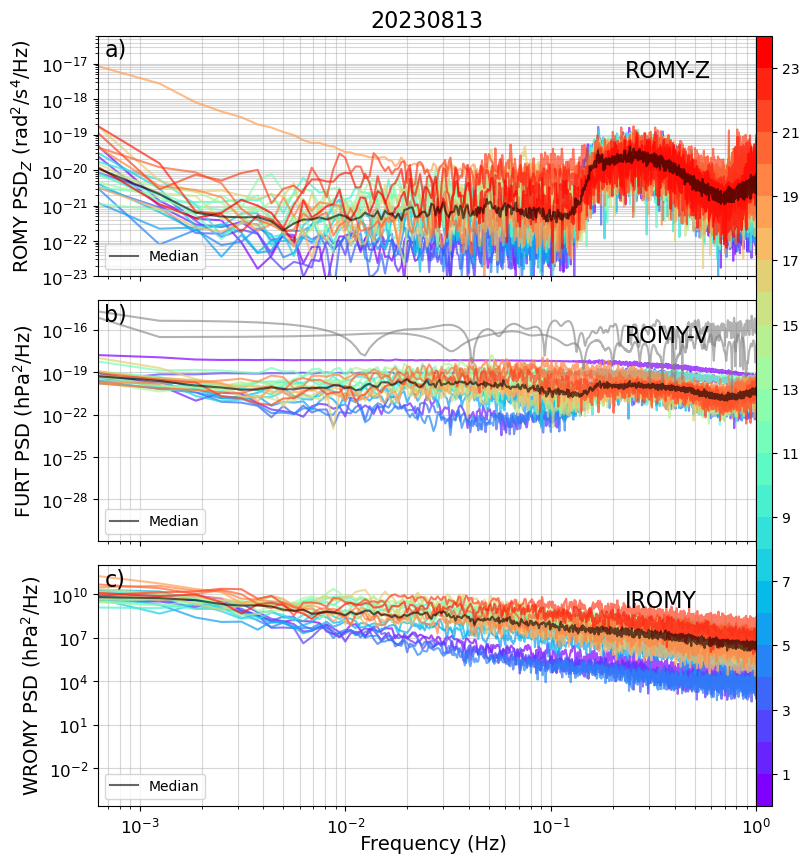

 -> saving: /import/kilauea-data/LNM2/figures/joint_IROMY_20230813.png
20230814
 -> removed 1 rows due to mean thresholds!
 -> 23 psds remain
 -> removed 2 rows due to mean thresholds!
 -> 22 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 23 psds remain


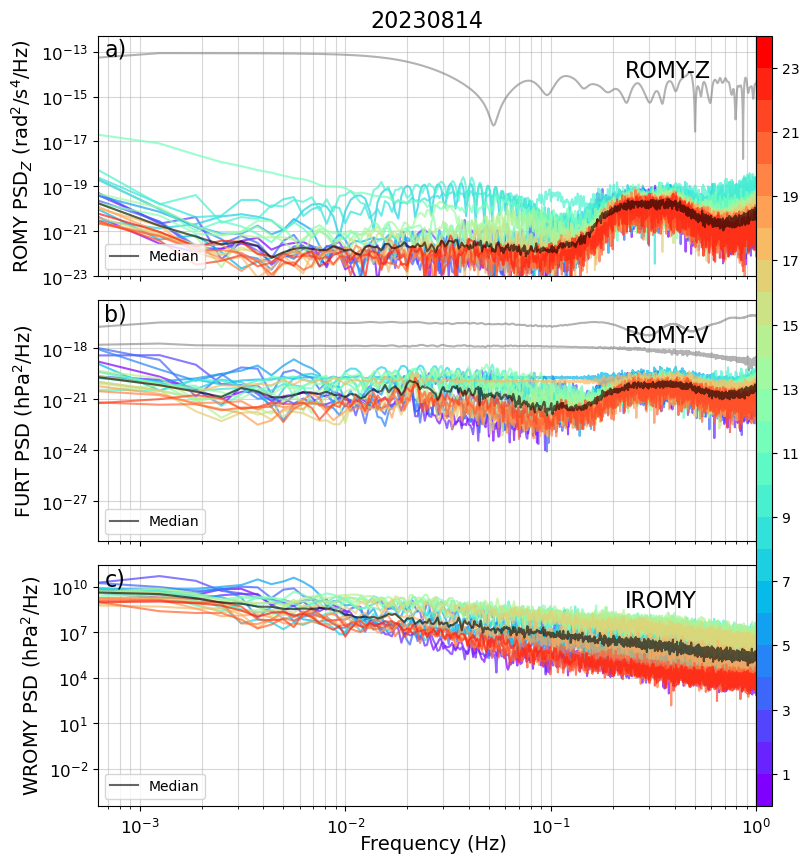

 -> saving: /import/kilauea-data/LNM2/figures/joint_IROMY_20230814.png
20230815
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 3 rows due to mean thresholds!
 -> 21 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 23 psds remain


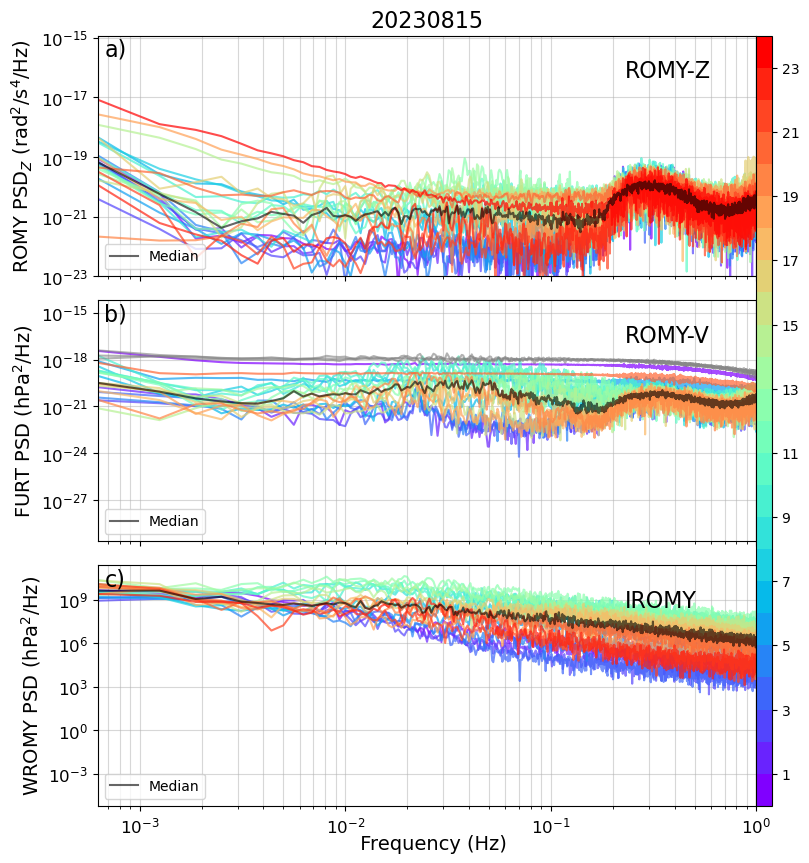

 -> saving: /import/kilauea-data/LNM2/figures/joint_IROMY_20230815.png
20230816
 -> removed 1 rows due to mean thresholds!
 -> 23 psds remain
 -> removed 4 rows due to mean thresholds!
 -> 20 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 23 psds remain


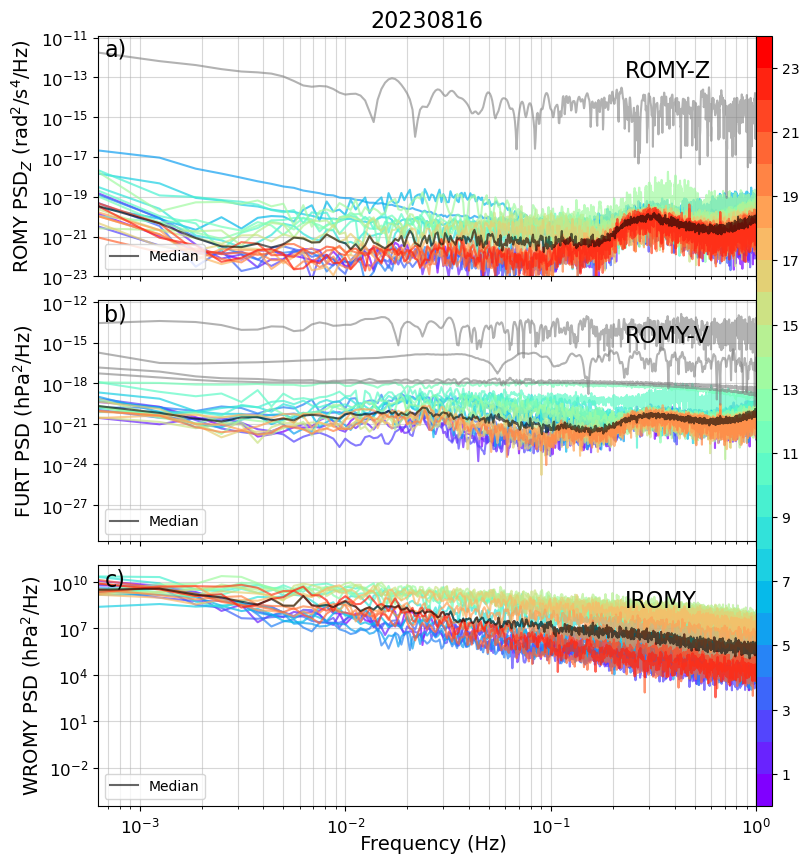

 -> saving: /import/kilauea-data/LNM2/figures/joint_IROMY_20230816.png
20230817
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 4 rows due to mean thresholds!
 -> 20 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 23 psds remain


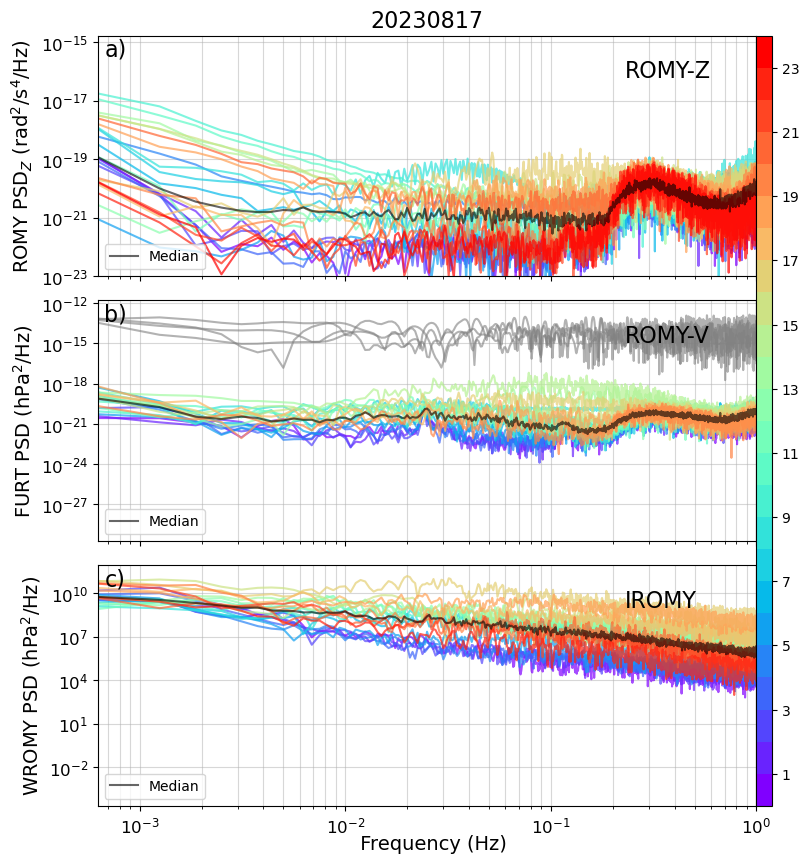

 -> saving: /import/kilauea-data/LNM2/figures/joint_IROMY_20230817.png
20230818
 -> removed 1 rows due to mean thresholds!
 -> 23 psds remain
 -> removed 3 rows due to mean thresholds!
 -> 21 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 23 psds remain


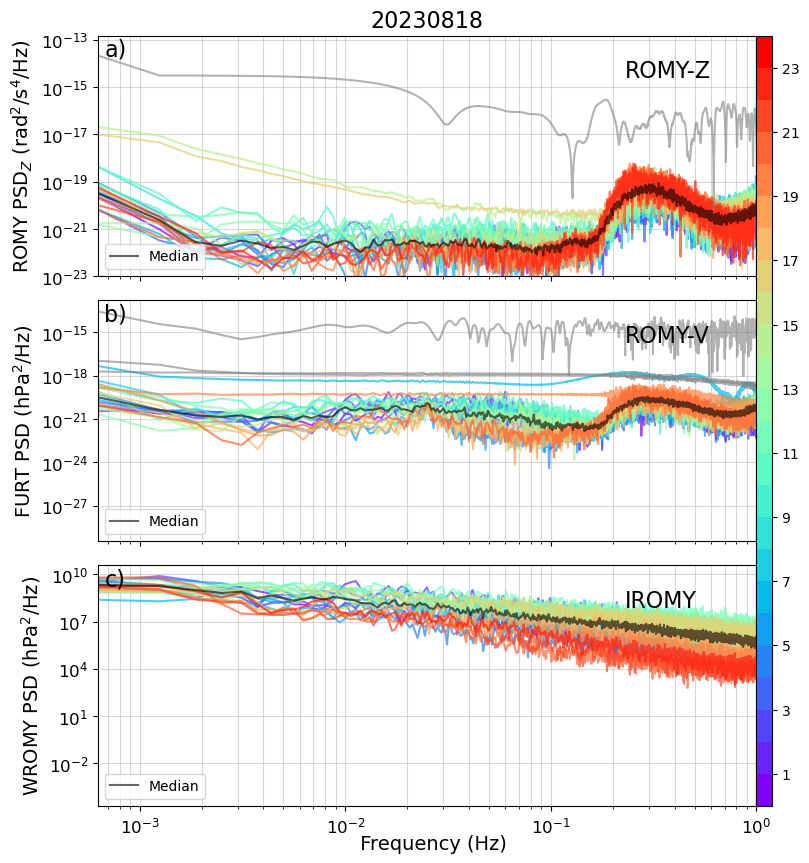

 -> saving: /import/kilauea-data/LNM2/figures/joint_IROMY_20230818.png
20230819
 -> removed 1 rows due to mean thresholds!
 -> 23 psds remain
 -> removed 1 rows due to mean thresholds!
 -> 23 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 23 psds remain


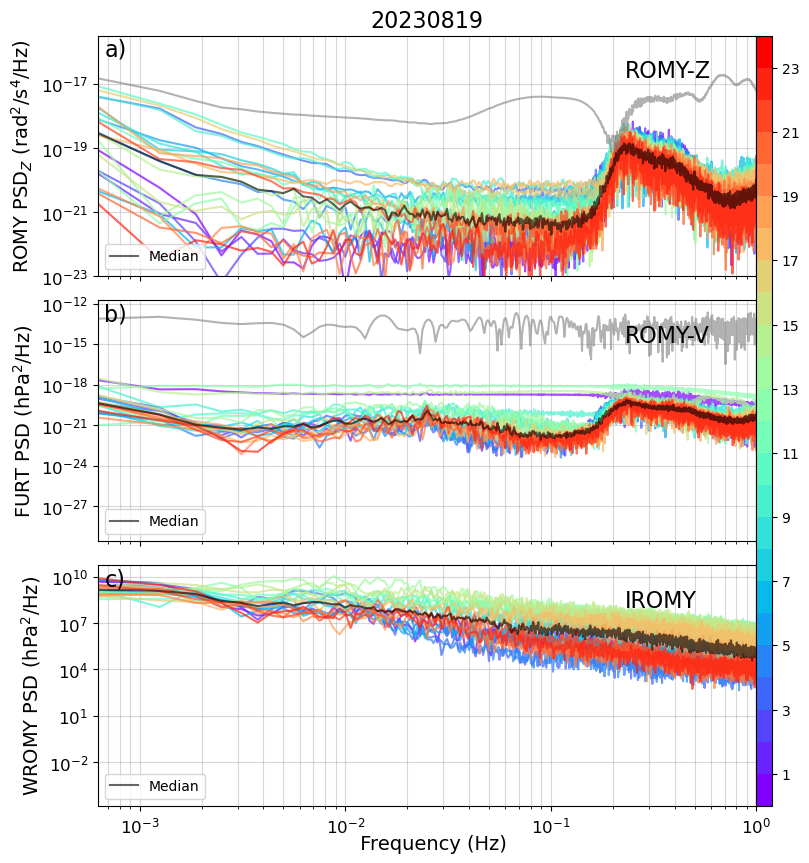

 -> saving: /import/kilauea-data/LNM2/figures/joint_IROMY_20230819.png
20230820
 -> removed 1 rows due to mean thresholds!
 -> 23 psds remain
 -> removed 7 rows due to mean thresholds!
 -> 17 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 23 psds remain


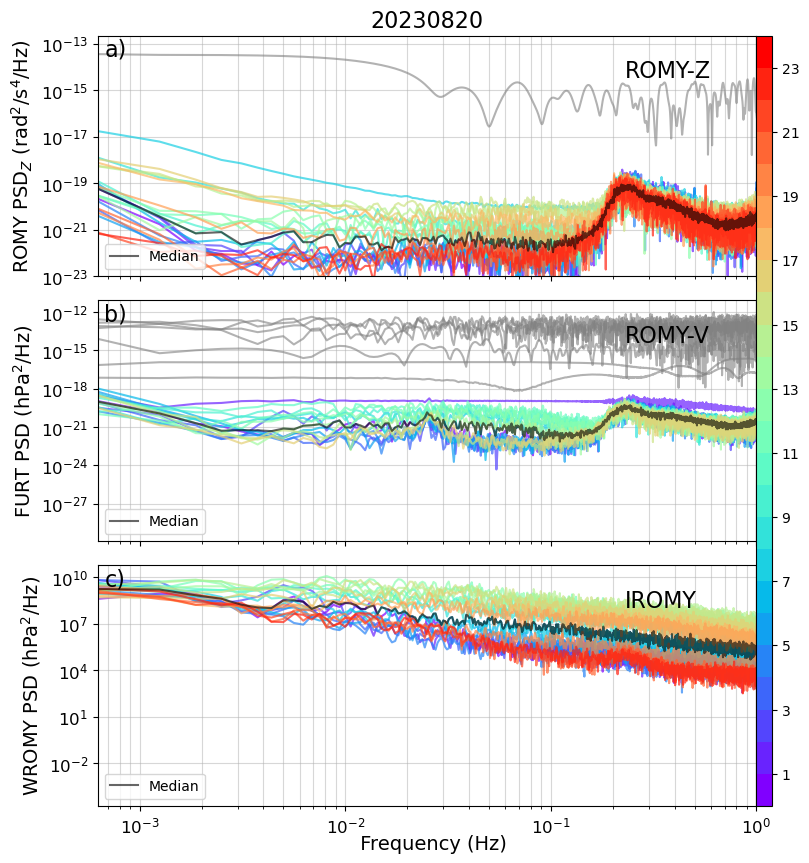

 -> saving: /import/kilauea-data/LNM2/figures/joint_IROMY_20230820.png


In [15]:
config['files'] = [file for file in os.listdir(config['inpath']) if "hourly" in file]
config['files'].sort()

d1, d2 = "2023-08-13", "2023-08-20"

psds_medians_out, times_out = [],[]

# for file in config['files']:
for day in date_range(d1,d2):

    # day = file.split("_")[-2]
    # print(day)

    day = str(day).split(" ")[0].replace("-","")
    print(day)

    config['outpath_figname'] = "joint_IROMY_"+day

    if os.path.isfile(config['outpath_figures']+config['outpath_figname']):
        continue

    try:

        ## Data1 --------------------------
        name = "ROMY/2023_ROMY_Z"
        ff1 = pickle.load(open(path+f"{name}_3600_frequency_axis.pkl", 'rb'))
        dat1 = __load_data_file(path,f"{name}_3600_{day}_hourly.pkl")
        dat1, rejected_dat1 = __remove_noisy_psds(dat1, threshold_mean=1e-18, ff=ff1, flim=0.1)
        # dat1, ff1 = __cut_frequencies_array(dat1, ff1, config['frequency_limits'][0], config['frequency_limits'][1])

        ## Data2 --------------------------
        name = "ROMY/2023_ROMY_V"
        ff2 = pickle.load(open(path+f"{name}_3600_frequency_axis.pkl", 'rb'))
        dat2 = __load_data_file(path,f"{name}_3600_{day}_hourly.pkl")
        dat2, rejected_dat2 = __remove_noisy_psds(dat2, threshold_mean=1e-18, ff=ff1, flim=0.1)
        # dat2, ff2 = __cut_frequencies_array(dat2, ff2, config['frequency_limits'][0], config['frequency_limits'][1])

        ## Data3 --------------------------
        name = "IROMY/2023_IROMY"
        ff3 = pickle.load(open(path+f"{name}_3600_frequency_axis.pkl", 'rb'))
        dat3 = __load_data_file(path,f"{name}_3600_{day}_hourly.pkl")
        dat3, rejected_dat3 = __remove_noisy_psds(dat3, threshold_mean=1e15, ff=ff1, flim=0.1)
        # dat3, ff3 = __cut_frequencies_array(dat3, ff3, config['frequency_limits'][0], config['frequency_limits'][1])


        ## ROMY-Z --------------------------
        # ff_rot_z = pickle.load(open(path+f"ROMY/2023_ROMY_V_3600_frequency_axis.pkl", 'rb'))
        # rot_z = __load_data_file(path,f"ROMY/2023_ROMY_V_3600_{day}_hourly.pkl")
        # rot_z, rejected_rot = __remove_noisy_psds(rot_z, threshold_mean=1e-18, ff=ff_rot_z, flim=0.1)
        # rot_z, ff_rot_z = __cut_frequencies_array(rot_z, ff_rot_z, config['frequency_limits'][0], config['frequency_limits'][1])

        ## FURT --------------------------
        # ff_furt = pickle.load(open(path+f"FURT/2023_FURT_3600_frequency_axis.pkl", 'rb'))
        # furt = __load_data_file(path,f"FURT/2023_FURT_3600_{day}_hourly.pkl")
        # furt, rejected_furt = __remove_noisy_psds(furt, threshold_mean=1e2)
        # furt, ff_furt = __cut_frequencies_array(furt, ff_furt, config['frequency_limits'][0], config['frequency_limits'][1])

        ## WROMY WS1 --------------------------
        # ff_wromy = pickle.load(open(path+f"WROMY_WS1/2023_WROMY_WS1_3600_frequency_axis.pkl", 'rb'))
        # wromy = __load_data_file(path,f"WROMY_WS1/2023_WROMY_WS1_3600_{day}_hourly.pkl")
        # wromy, rejected_wromy = __remove_noisy_psds(wromy, threshold_mean=1e2)
#         wromy, ff_wromy = __cut_frequencies_array(wromy, ff_wromy, config['frequency_limits'][0], config['frequency_limits'][1])

        ## IROMY --------------------------
#         ff_furt = pickle.load(open(path+f"IROMY/2023_IROMY_3600_frequency_axis.pkl", 'rb'))
#         furt = __load_data_file(path,f"IROMY/2023_IROMY_3600_{day}_hourly.pkl")
#         furt, rejected_furt = __remove_noisy_psds(furt, threshold_mean=1e14)
#         # furt, ff_furt = __cut_frequencies_array(furt, ff_furt, config['frequency_limits'][0], config['frequency_limits'][1])

#         ## WROMY WS7--------------------------
#         ff_wromy = pickle.load(open(path+f"WROMY_WS7/2023_WROMY_WS7_3600_frequency_axis.pkl", 'rb'))
#         wromy = __load_data_file(path,f"WROMY_WS7/2023_WROMY_WS7_3600_{day}_hourly.pkl")
#         wromy, rejected_wromy = __remove_noisy_psds(wromy, threshold_mean=1e2)
# #         wromy, ff_wromy = __cut_frequencies_array(wromy, ff_wromy, config['frequency_limits'][0], config['frequency_limits'][1])

    except:
        continue


    fig = __makeplot_colorlines_overview(config,
                                         [ff1, ff2, ff3],
                                         [dat1, dat2, dat3],
                                         [rejected_dat1, rejected_dat2, rejected_dat3],
                                         day)

    print(f" -> saving: {config['outpath_figures']}{config['outpath_figname']}.png")
    fig.savefig(config['outpath_figures']+config['outpath_figname']+".png", format="png", transparent=False, bbox_inches='tight', dpi=200)

In [16]:
    ## output data
#     psds_medians_out.append(psds_median)
#     times_out.append(time)

# ## write output
# output = {"times": array(times_out).astype(int), "frequencies": array(ff), "psds_medians": array(psds_medians_out)}

# with open(f"{config['inpath']}{config['inname']}_psds_filtered_medians.pkl", 'wb') as file:
#     pickle.dump(output, file, protocol=pickle.HIGHEST_PROTOCOL)